In [1]:
import sys
sys.path.insert(0, "/work/04233/sw33286/AIDA-SCRIPTS")

In [2]:
import random
import numpy as np

import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell, MultiRNNCell, DropoutWrapper

from helpers import Indexer, batch
from itertools import chain

### Prepare data

In [3]:
TYPES = ['ANIMAL','VEHICLE','NATURE','FURNITURE','FRUIT']
TYPE2VOCAB = {'ANIMAL': ['cat','dog','pig','horse','deer'],
              'VEHICLE': ['car','bike','motorcycle','train','bus'],
              'NATURE': ['hill','mountain','lake','river','valley'],
              'FURNITURE': ['stool','table','closet','cabinet','bed'],
              'FRUIT': ['apple','pear','strawberry','grape','tomato']}
VOCAB = list(chain.from_iterable(TYPE2VOCAB.values()))

indexer = Indexer()
indexer.get_index('PAD')
for word in VOCAB:
    indexer.get_index(word)

In [4]:
FROM_LEN = 5
TO_LEN = 15
CTX_LEN = 10

def get_context(type1, type2):
    return [indexer.get_index(w) for w in TYPE2VOCAB[type1]] + \
           [indexer.get_index(w) for w in TYPE2VOCAB[type2]]

def generate_datum(from_len=FROM_LEN, to_len=TO_LEN):
    y = 0 if np.random.rand() < 0.5 else 1
    x1_length = np.random.randint(from_len, to_len)
    x2_length = np.random.randint(from_len, to_len)
    x1_type = np.random.choice(TYPES)
    x2_type = np.random.choice([t for t in TYPES if t!=x1_type]) if y==0 else x1_type
    x1_code = [indexer.get_index(np.random.choice(TYPE2VOCAB[x1_type])) for _ in range(x1_length)]
    x2_code = [indexer.get_index(np.random.choice(TYPE2VOCAB[x2_type])) for _ in range(x2_length)]
    ctx_code = get_context(x1_type, x2_type)
    return x1_code, x2_code, ctx_code, y

def to_sent(code):
    return [indexer.get_object(idx) for idx in code]

def get_batch(n, from_len=FROM_LEN, to_len=TO_LEN):
    x1_batch, x2_batch, ctx_batch, y_batch = [], [], [], []
    for _ in range(n):
        x1_code, x2_code, ctx_code, y = generate_datum(from_len, to_len)
        x1_batch.append(x1_code)
        x2_batch.append(x2_code)
        ctx_batch.append(ctx_code)
        y_batch.append(y)
    x1_batch, x1_batch_len = batch(x1_batch)
    x2_batch, x2_batch_len = batch(x2_batch)
    return x1_batch, x1_batch_len, x2_batch, x2_batch_len, np.array(ctx_batch), np.array(y_batch)

### Stacked Bi-LSTM

In [9]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

VOCAB_SIZE = len(indexer)
EMB_SIZE = 20
HID_SIZE = 10
NUM_LAYERS = 2
KEEP_PROB = 0.7

input_x1 = tf.placeholder(tf.int32, [None, None], name='input_x1') # <max-time, batch-size>
input_x2 = tf.placeholder(tf.int32, [None, None], name='input_x2')
input_x1_length = tf.placeholder(tf.int32, [None], name='input_x1_length')
input_x2_length = tf.placeholder(tf.int32, [None], name='input_x2_length')
input_ctx = tf.placeholder(tf.int32, [None, CTX_LEN], name='input_ctx')
input_y  = tf.placeholder(tf.int32, [None], name='input_y')

with tf.variable_scope('Embeddings'):
    embeddings = tf.get_variable('embeddings', [VOCAB_SIZE, EMB_SIZE], 
                                 initializer=tf.contrib.layers.xavier_initializer())
    input_x1_embedded = tf.nn.embedding_lookup(embeddings, input_x1) # <max-time, batch-size, emb-size>
    input_x2_embedded = tf.nn.embedding_lookup(embeddings, input_x2)
    input_ctx_embedded = tf.nn.embedding_lookup(embeddings, input_ctx)

cell = MultiRNNCell([DropoutWrapper(LSTMCell(HID_SIZE),output_keep_prob=KEEP_PROB)]*NUM_LAYERS) 

def run_lstm(cell, inputs, inputs_length): # lstm-out size *= 2 by bidirectionality.
    ((fw_outputs,bw_outputs), # <max-time, batch-size, hid-size>, attention later if needed.
     (fw_final_state,bw_final_state)) = ( # <batch-size, hid-size>
        tf.nn.bidirectional_dynamic_rnn(cell_fw=cell,
                                        cell_bw=cell,
                                        inputs=inputs,
                                        sequence_length=inputs_length,
                                        dtype=tf.float32, time_major=True)
    )
    return tf.concat([tf.concat([fw_state_tuple.h,bw_state_tuple.h], 1) # lstm-out size *= NUM_LAYERS by stacking.
                      for fw_state_tuple,bw_state_tuple in zip(fw_final_state,bw_final_state)], 1)
    
with tf.variable_scope('Bi-LSTM') as scope:
    final_state_x1 = run_lstm(cell, input_x1_embedded, input_x1_length)
    scope.reuse_variables() # both sentence inputs share the same weights.
    final_state_x2 = run_lstm(cell, input_x2_embedded, input_x2_length)
    
lstm_out_size = HID_SIZE * 2 * NUM_LAYERS
ctx_size = lstm_out_size/2 # contribution from context.
with tf.variable_scope('ContextWeights'), tf.device('/cpu:0'):
    W_ctx = tf.get_variable('W_ctx', [CTX_LEN*EMB_SIZE, ctx_size], 
                            initializer=tf.contrib.layers.xavier_initializer())
    b_ctx = tf.get_variable('b_ctx', [ctx_size],
                            initializer=tf.contrib.layers.xavier_initializer())
    ctx = tf.nn.xw_plus_b(tf.reshape(input_ctx_embedded,[-1,CTX_LEN*EMB_SIZE]),W_ctx,b_ctx)
final_state_x1 = tf.concat([final_state_x1, ctx], 1)
final_state_x2 = tf.concat([final_state_x2, ctx], 1)

W_bi = tf.get_variable('W_bi', [lstm_out_size+ctx_size, lstm_out_size+ctx_size], initializer=tf.contrib.layers.xavier_initializer())
scores = tf.nn.sigmoid(tf.diag_part(tf.matmul(tf.matmul(final_state_x1,W_bi),tf.transpose(final_state_x2))))
predictions = tf.cast(tf.round(scores), tf.int32, name='predictions') 

with tf.name_scope('loss'):
    losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(input_y, tf.float32), logits=scores)
    loss = tf.reduce_mean(losses)

with tf.name_scope('accuracy'):
    correct_predictions = tf.equal(predictions, input_y)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
    
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(1e-4)
grads_and_vars = optimizer.compute_gradients(loss)
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

sess.run(tf.global_variables_initializer())

In [10]:
NUM_EPOCHS = 1
NUM_BATCHES = 1000
BATCH_SIZE = 32
VERBOSE = 100

loss_track, accuracy_track = [], []
for e in range(NUM_EPOCHS):
    print('Epoch ', e+1)
    print('\n')
    curr_loss_track, curr_accuracy_track = [], []
    for _ in range(NUM_BATCHES):
        batch_x1, batch_x1_length, batch_x2, batch_x2_length, batch_ctx, batch_y = get_batch(32)
        fd = {input_x1:batch_x1, input_x1_length:batch_x1_length,
              input_x2:batch_x2, input_x2_length:batch_x2_length,
              input_ctx:batch_ctx,
              input_y:batch_y}
        _, step, loss_, accuracy_ = sess.run([train_op, global_step, loss, accuracy], feed_dict=fd)
        curr_loss_track.append(loss_)
        curr_accuracy_track.append(accuracy_)
        if step%VERBOSE==0:
            print('  batch loss & accuracy at step {}: <{}, {}>'.format(step, loss_, accuracy_))
    print('\n')
    print('  epoch mean loss & accuracy: <{}, {}>'.format(np.mean(curr_loss_track),np.mean(curr_accuracy_track)))
    print('\n')    
    loss_track += curr_loss_track
    accuracy_track += curr_accuracy_track

Epoch  1


  batch loss & accuracy at step 100: <0.6985721588134766, 0.625>
  batch loss & accuracy at step 200: <0.7390413880348206, 0.8125>
  batch loss & accuracy at step 300: <0.583633542060852, 1.0>
  batch loss & accuracy at step 400: <0.6183696985244751, 1.0>
  batch loss & accuracy at step 500: <0.5262870788574219, 1.0>
  batch loss & accuracy at step 600: <0.47152605652809143, 1.0>
  batch loss & accuracy at step 700: <0.5682690143585205, 1.0>
  batch loss & accuracy at step 800: <0.5440136194229126, 1.0>
  batch loss & accuracy at step 900: <0.4830697178840637, 1.0>
  batch loss & accuracy at step 1000: <0.5655384063720703, 1.0>


  epoch mean loss & accuracy: <0.5689961910247803, 0.9021250009536743>




### Plotting loss & accuracy

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_tracks(step_size):
    t = np.arange(len(loss_track))[::step_size]
    fig, ax1 = plt.subplots()
    color = 'r'
    ax1.set_xlabel('Combined Loss vs. Accuracy Tracks')
    ax1.set_ylabel('Combined Loss')
    ax1.plot(t, loss_track[::step_size], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'b'
    ax2.set_ylabel('Clustering Accuracy', color=color)
    ax2.plot(t, accuracy_track[::step_size], color=color)
    ax2.tick_params(axis='y',labelcolor=color)
    fig.tight_layout()
    plt.show()    

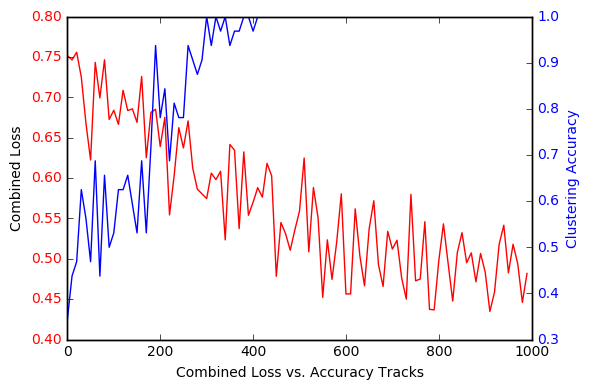

In [12]:
plot_tracks(step_size=10)